In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import clear_output

from models import Generator, PatchGAN
from models_utils import *

%matplotlib inline
%load_ext autotime

C:\Users\т\AppData\Local\Programs\Python\Python37\Scripts\kurs\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] Не найден указанный модуль
  warn(f"Failed to load image Python extension: {e}")


time: 0 ns (started: 2022-02-13 16:49:00 +03:00)


<h2>1) Получение данных

Данные берутся те же, что использовались в оригинальной статье.

In [2]:
def get_loaders(batch_size, image_size, test = False):
    """
    Функция предполагает наличие распакованных данных с http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/
    """
    
    dir_name = 'horse2zebra/horse2zebra/'
    if test:
        A = 'testA/'
        B = 'testB/'
    else:
        A = 'trainA/'
        B = 'trainB/'
    filesA = [os.path.join(dir_name + A, x) for x in os.listdir(dir_name + A)]
    filesB = [os.path.join(dir_name + B, x) for x in os.listdir(dir_name + B)]

    trans = tt.Compose([
        tt.ToTensor(),
        tt.Resize(image_size),
        tt.Normalize((0, 0, 0), (1, 1, 1)),
    ])

    def get_images(files, image_size):
        images = []
        for file in files:
            try:
                im = trans(Image.open(file))
                if im.shape[0] == 3:
                    images.append(im)
            except:
                pass
        return torch.stack(images)

    imagesA = get_images(filesA, image_size)
    imagesB = get_images(filesB, image_size)
    loaderA = DataLoader(imagesA, batch_size=batch_size, num_workers=0, shuffle=True, drop_last=True)
    loaderB = DataLoader(imagesB, batch_size=batch_size, num_workers=0, shuffle=True, drop_last=True)
    return loaderA, loaderB

time: 16 ms (started: 2022-02-13 16:49:00 +03:00)


In [3]:
batch_size = 2
loaderA, loaderB = get_loaders(batch_size, 256)

time: 6.88 s (started: 2022-02-13 16:49:02 +03:00)


<h2>2) Обучение

Модели определены в файле models.py

In [4]:
#generator, discriminator, opt = init_models(lr = 0.0005, n_res = 9)
generator, discriminator, opt, losses = load_models('h2z.pt')

time: 687 ms (started: 2022-02-13 16:49:09 +03:00)


In [5]:
criterion_gan = nn.MSELoss()
criterion_cycle = nn.L1Loss()

time: 0 ns (started: 2022-02-13 16:49:10 +03:00)


In [6]:
device = torch.device('cuda')

ones = torch.ones(batch_size, 1, 8, 8, device=device)
zeros = torch.zeros(batch_size, 1, 8, 8, device=device)

def set_req_grad(models, req):
    for model in models:
        for param in model.parameters():
            param.requires_grad = req

def train_discriminator(discr, opt, criterion, real, fake):
    opt.zero_grad()
    output = discr(real)
    loss = criterion(output, ones)/2
    
    output = discr(fake.detach())
    loss += criterion(output, zeros)/2
    loss.backward()
    opt.step()
    return loss.item()

def train_generator(opt, discr, criterion, fake):
    output = discr(fake)
    loss = criterion(output, ones)
    loss.backward(retain_graph=True)
    return loss.item()

def train(epochs, prev_losses, lmbda=10):
    if prev_losses:
        losses = prev_losses
    else:
        losses = {
            'discr': {
                'A': [],
                'B': []
            },
            'gen': {
                'A': [],
                'B': [],
                'cycle': []
            }
        }
    for epoch in range(epochs):
        epoch_losses = {
            'discr': {
                'A': [],
                'B': []
            },
            'gen': {
                'A': [],
                'B': [],
                'cycle': []
            }
        }
        iterB = iter(loaderB)
        for A in loaderA:
            B = next(iterB)

            A = A.cuda()
            B = B.cuda()

            B_fake = generator['B'](A)
            A_fake = generator['A'](B)
            
            set_req_grad([discriminator['A'], discriminator['B']], False)
            
            opt['gen']['A'].zero_grad()
            opt['gen']['B'].zero_grad()
            
            epoch_losses['gen']['A'].append(train_generator(opt['gen']['A'], discriminator['A'], criterion_gan, A_fake))
            epoch_losses['gen']['B'].append(train_generator(opt['gen']['B'], discriminator['B'], criterion_gan, B_fake))
            
            A_repr = generator['A'](B_fake)
            B_repr = generator['B'](A_fake)
            
            cycle_loss = criterion_cycle(A_repr, A)
            cycle_loss += criterion_cycle(B_repr, B)
            cycle_loss *= lmbda
            
            cycle_loss.backward()
            
            epoch_losses['gen']['cycle'].append(cycle_loss.item())
            opt['gen']['A'].step()
            opt['gen']['B'].step()
            
            set_req_grad([discriminator['A'], discriminator['B']], True)
            
            epoch_losses['discr']['A'].append(train_discriminator(discriminator['A'], opt['discr']['A'], criterion_gan, A, A_fake.detach()))
            epoch_losses['discr']['B'].append(train_discriminator(discriminator['B'], opt['discr']['B'], criterion_gan, B, B_fake.detach()))
        for k1 in losses:
            for k2 in losses[k1]:
                losses[k1][k2].append(sum(epoch_losses[k1][k2]) / len(epoch_losses[k1][k2]))
        clear_output(wait=True)
        print('Epoch: '+ str(epoch))
    clear_output(wait=True)
    return losses

time: 1.47 s (started: 2022-02-13 16:49:10 +03:00)


In [7]:
losses = train(1, losses)

KeyboardInterrupt: 

time: 19.8 s (started: 2022-02-13 16:49:11 +03:00)


In [100]:
save_models(generator, discriminator, opt, losses, 'h2z.pt')

time: 844 ms (started: 2022-02-07 22:00:18 +03:00)


Графики лоссов (скачок соответствует уменьшению градиентного шага с 0.0005 до 0.0001)

Лоссы дискриминантов

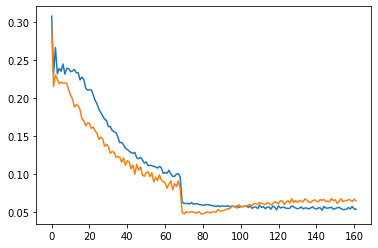

time: 110 ms (started: 2022-02-13 16:49:34 +03:00)


In [8]:
plt.plot(losses['discr']['A'])
plt.plot(losses['discr']['B'])

In [25]:
torch.save(generator['A'].state_dict(), 'pretrained/h2z_dict.pt')

time: 47 ms (started: 2022-02-13 17:35:34 +03:00)


Лоссы генераторов (зеленым cycle loss)

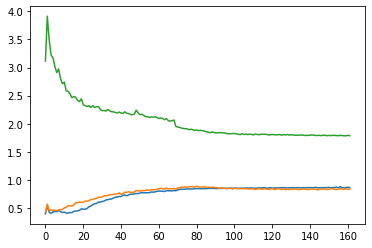

time: 93 ms (started: 2022-02-13 16:49:35 +03:00)


In [9]:
plt.plot(losses['gen']['A'])
plt.plot(losses['gen']['B'])
plt.plot(losses['gen']['cycle'])

<h2>3) Генерация

In [20]:
loaderA, loaderB = get_loaders(batch_size, 256, test = True)

generator = {}
generator['A'] = torch.load('pretrained/zebra2horse.pt')
generator['B'] = torch.load('pretrained/horse2zebra.pt')

time: 609 ms (started: 2022-02-13 17:01:33 +03:00)


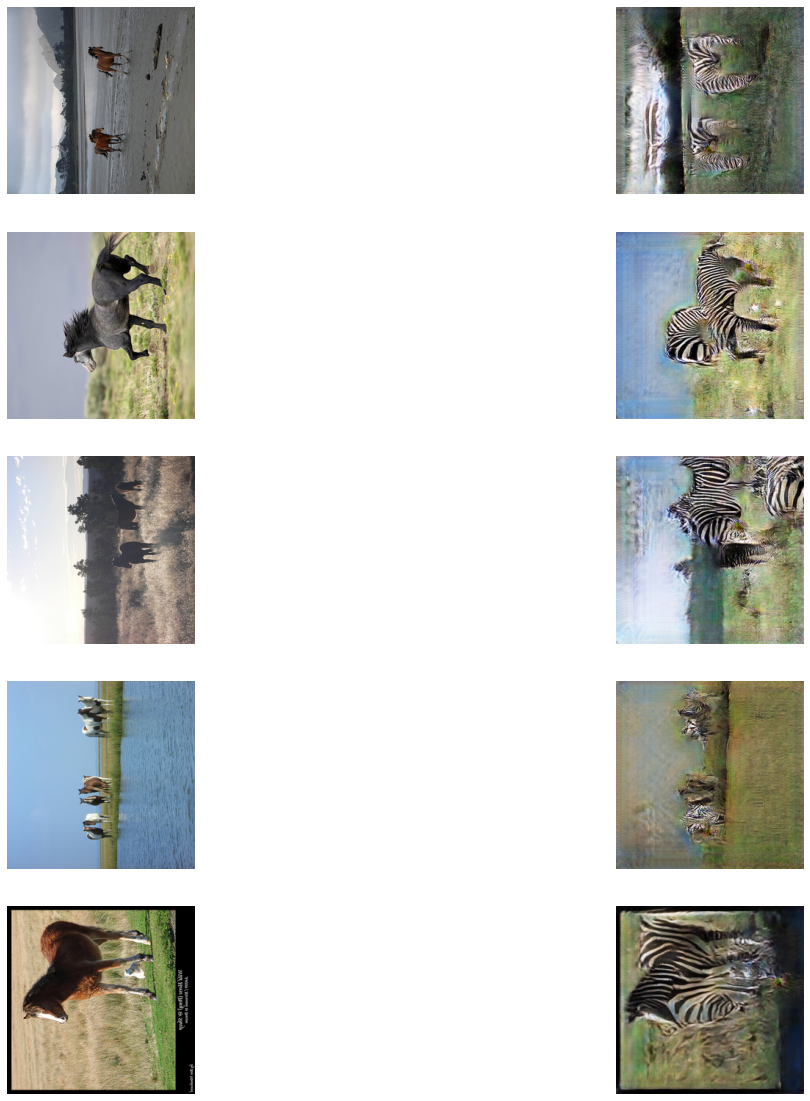

time: 3.99 s (started: 2022-02-13 17:01:47 +03:00)


In [22]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))

for ax in axs:
    x = next(iter(loaderA))[0, None]
    y = generator['B'].cpu()(x.float())[0].detach()
    ax[0].imshow(x[0].swapaxes(0, 2))
    ax[1].imshow(y.swapaxes(0, 2))
    for axx in ax:
        axx.axis('Off')

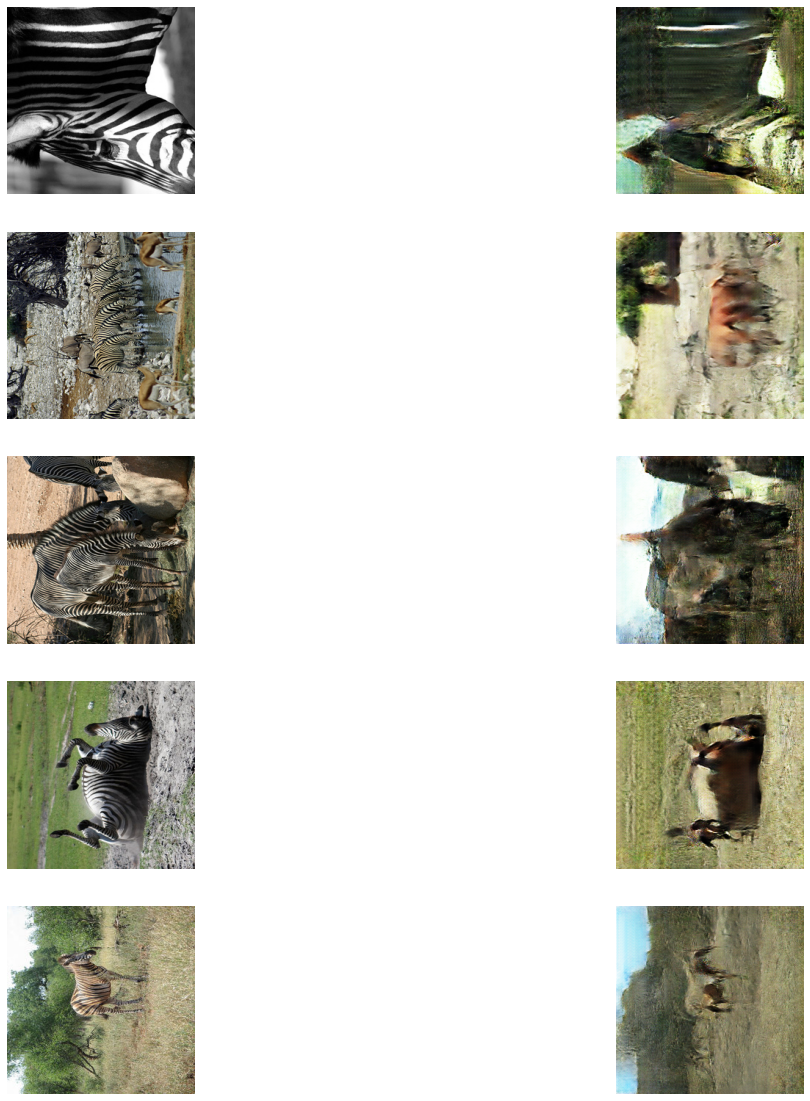

time: 4 s (started: 2022-02-13 17:30:44 +03:00)


In [24]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))

for ax in axs:
    x = next(iter(loaderB))[0, None]
    y = generator['A'].cpu()(x.float())[0].detach()
    ax[0].imshow(x[0].swapaxes(0, 2))
    ax[1].imshow(y.swapaxes(0, 2))
    for axx in ax:
        axx.axis('Off')